In [1]:
import sys
import os

# Add the parent directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import src.config as config

In [2]:
import hopsworks

project = hopsworks.login(
    project=config.HOPSWORKS_PROJECT_NAME, api_key_value=config.HOPSWORKS_API_KEY
)

feature_store = project.get_feature_store()
feature_group = feature_store.get_feature_group(
    name=config.FEATURE_GROUP_NAME,
    version=config.FEATURE_GROUP_VERSION
)

2025-03-05 19:52:46,852 INFO: Initializing external client
2025-03-05 19:52:46,852 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-03-05 19:52:48,599 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1214717


In [3]:
# Create a feature view if it doesn't already exist
try:
    feature_store.create_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
        query=feature_group.select_all(),
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) created successfully.")
except Exception as e:
    print(f"Error creating feature view: {e}")

# Retrieve the feature view
try:
    feature_view = feature_store.get_feature_view(
        name=config.FEATURE_VIEW_NAME,
        version=config.FEATURE_VIEW_VERSION,
    )
    print(f"Feature view '{config.FEATURE_VIEW_NAME}' (version {config.FEATURE_VIEW_VERSION}) retrieved successfully.")
except Exception as e:
    print(f"Error retrieving feature view: {e}")

Error creating feature view: Metadata operation error: (url: https://c.app.hopsworks.ai/hopsworks-api/api/project/1214717/featurestores/1202349/featureview). Server response: 
HTTP code: 400, HTTP reason: Bad Request, body: b'{"errorCode":270179,"usrMsg":"Feature view: time_series_hourly_feature_view, version: 1","errorMsg":"The provided feature view name and version already exists"}', error code: 270179, error msg: The provided feature view name and version already exists, user msg: Feature view: time_series_hourly_feature_view, version: 1
Feature view 'time_series_hourly_feature_view' (version 1) retrieved successfully.


In [4]:
ts_data, _ = feature_view.training_data(
    description="Time-series hourly taxi rides"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (11.73s) 


In [5]:
ts_data = ts_data.sort_values(["pickup_location_id", "pickup_hour"]).reset_index(drop=True)

In [6]:
ts_data.head()

,pickup_hour,pickup_location_id,rides
0,2023-01-01 00:00:00+00:00,2,0
1,2023-01-01 01:00:00+00:00,2,0
2,2023-01-01 02:00:00+00:00,2,0
3,2023-01-01 03:00:00+00:00,2,0
4,2023-01-01 04:00:00+00:00,2,0


In [7]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453244 entries, 0 to 2453243
Data columns (total 3 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   pickup_hour         object
 1   pickup_location_id  int32 
 2   rides               int32 
dtypes: int32(2), object(1)
memory usage: 37.4+ MB


In [8]:
ts_data["pickup_hour"].min()

'2023-01-01 00:00:00+00:00'

In [9]:
ts_data["pickup_hour"].max()

'2025-03-05 18:00:00+00:00'

In [10]:
import pandas as pd
ts_data["pickup_hour"] = pd.to_datetime(ts_data["pickup_hour"], errors="coerce")

In [11]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453244 entries, 0 to 2453243
Data columns (total 3 columns):
 #   Column              Dtype              
---  ------              -----              
 0   pickup_hour         datetime64[ns, UTC]
 1   pickup_location_id  int32              
 2   rides               int32              
dtypes: datetime64[ns, UTC](1), int32(2)
memory usage: 37.4 MB


In [12]:
ts_data["pickup_hour"] = ts_data["pickup_hour"].dt.tz_localize(None)  # Remove timezone

In [13]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453244 entries, 0 to 2453243
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
dtypes: datetime64[ns](1), int32(2)
memory usage: 37.4 MB


In [14]:
ts_data["year_month"] = ts_data["pickup_hour"].dt.to_period("M")  # Year-Month format

In [15]:
ts_data

,pickup_hour,pickup_location_id,rides,year_month
0,2023-01-01 00:00:00,2,0,2023-01
1,2023-01-01 01:00:00,2,0,2023-01
2,2023-01-01 02:00:00,2,0,2023-01
3,2023-01-01 03:00:00,2,0,2023-01
4,2023-01-01 04:00:00,2,0,2023-01
...,...,...,...,...
2453239,2025-03-05 14:00:00,263,136,2025-03
2453240,2025-03-05 15:00:00,263,153,2025-03
2453241,2025-03-05 16:00:00,263,181,2025-03
2453242,2025-03-05 17:00:00,263,215,2025-03


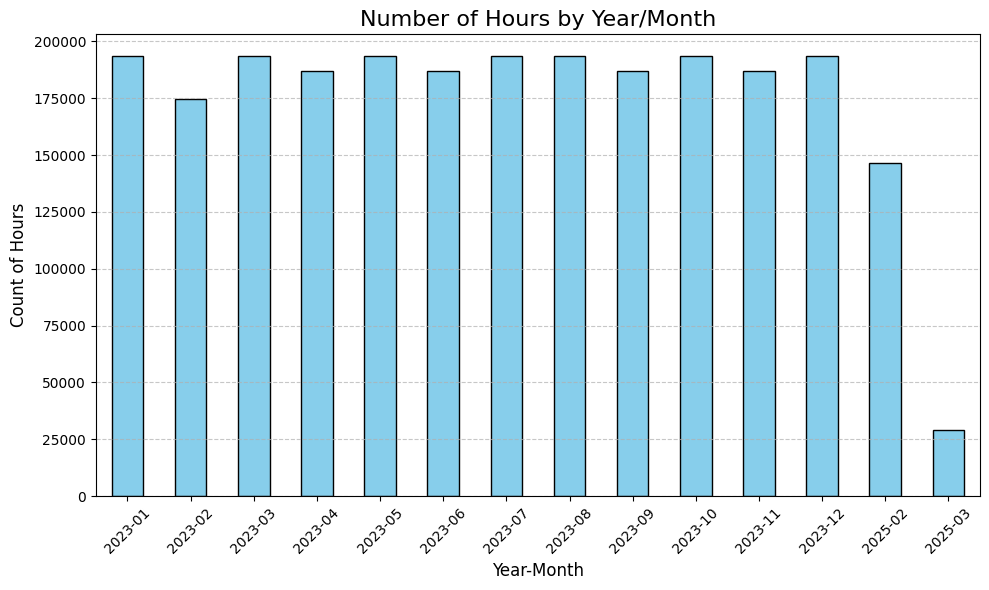

In [16]:
import matplotlib.pyplot as plt

# Group by year_month and count
hour_counts = ts_data.groupby("year_month").size()

# Plot the data
ax = hour_counts.plot(kind="bar", figsize=(10, 6), color="skyblue", edgecolor="black")  # Use 'ax' to store the plot object
ax.set_title("Number of Hours by Year/Month", fontsize=16)
ax.set_xlabel("Year-Month", fontsize=12)
ax.set_ylabel("Count of Hours", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [17]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2453244 entries, 0 to 2453243
Data columns (total 4 columns):
 #   Column              Dtype         
---  ------              -----         
 0   pickup_hour         datetime64[ns]
 1   pickup_location_id  int32         
 2   rides               int32         
 3   year_month          period[M]     
dtypes: datetime64[ns](1), int32(2), period[M](1)
memory usage: 56.2 MB


In [18]:
gte = ts_data["year_month"] >= pd.Period("2023-01", freq="M")
lte = ts_data["year_month"] <= pd.Period("2023-12", freq="M")
cond = gte & lte
filtered_data = ts_data[cond].reset_index(drop=True)

In [19]:
filtered_data.drop(columns=["year_month"], inplace=True) 

In [20]:
filtered_data.shape

(2277600, 3)

In [21]:
ts_data = filtered_data

In [22]:
from src.data_utils import transform_ts_data_info_features_and_target

features, targets = transform_ts_data_info_features_and_target(ts_data, window_size=24*28, step_size=23)

In [23]:
features.sort_values(["pickup_location_id", "pickup_hour"])

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91515,110,115,101,125,129,137,109,137,132,89,...,8,38,37,68,74,98,85,89,2023-12-27 13:00:00,263
91516,104,109,89,133,130,143,165,103,106,111,...,8,14,30,34,49,76,96,88,2023-12-28 12:00:00,263
91517,100,114,110,117,134,130,188,250,173,142,...,9,8,11,38,46,55,73,73,2023-12-29 11:00:00,263
91518,151,148,147,134,119,137,124,126,160,205,...,36,13,14,16,20,25,42,54,2023-12-30 10:00:00,263


In [24]:
features_copy = features.copy()

In [25]:
features_targets = features.copy()
features_targets["target"] = targets

features_targets.shape

(91520, 675)

In [26]:
import pandas as pd
from src.data_utils import split_time_series_data

# Define the start and end dates
start_date = pd.Timestamp("2023-01-01")
end_date = pd.Timestamp("2023-12-31")

# Calculate the total number of days in the date range
total_days = (end_date - start_date).days + 1

# Calculate the cutoff date for 80% training data
cutoff_days = int(total_days * 0.8)
cutoff_date = start_date + pd.Timedelta(days=cutoff_days)

cutoff_date


Timestamp('2023-10-20 00:00:00')

In [27]:
X_train, y_train, X_test, y_test = split_time_series_data(
    features_targets,
    cutoff_date=cutoff_date,
    target_column="target"
)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(71760, 674)
(71760,)
(19760, 674)
(19760,)


In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71760 entries, 0 to 71759
Columns: 674 entries, rides_t-672 to pickup_location_id
dtypes: datetime64[ns](1), int32(1), int64(672)
memory usage: 368.7 MB


In [29]:
X_train.head()

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-8,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,pickup_location_id
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,2023-01-29 00:00:00,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-29 23:00:00,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-30 22:00:00,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-01-31 21:00:00,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2023-02-01 20:00:00,2


In [30]:
# Define the hyperparameter grid
param_grid = {
    'lgbmregressor__n_estimators': [100, 200, 300],
    'lgbmregressor__learning_rate': [0.01, 0.05, 0.1],
    'lgbmregressor__max_depth': [3, 5, 7],
    'lgbmregressor__colsample_bytree': [0.8, 0.9, 1.0],
    'lgbmregressor__subsample': [0.8, 0.9, 1.0],
    'lgbmregressor__reg_alpha': [0, 0.1, 0.5],
    'lgbmregressor__reg_lambda': [0, 0.1, 0.5]
}

In [31]:
from src.pipeline_utils import get_pipeline
pipeline = get_pipeline()

In [32]:
# Create RandomizedSearchCV object
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import joblib
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=3,  # Number of parameter settings sampled
    scoring='neg_mean_absolute_error',  # Use negative MAE for scoring (as GridSearchCV maximizes the score)
    cv=3,  # Cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=1  # Use all available cores
)

# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters found:", random_search.best_params_)
print("Best negative MAE score:", random_search.best_score_)

# Get the best model
best_model = random_search.best_estimator_

# --- 7. Evaluate the Best Model ---
predictions = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, predictions)
print(f"Test MAE with the best model: {test_mae:.4f}")

# --- 8. Model Registry and Saving ---
# Save the best model
joblib.dump(best_model, config.MODELS_DIR / "lgb_model.pkl")

Fitting 3 folds for each of 3 candidates, totalling 9 fits


ValueError: 
All the 9 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\pandas\core\indexes\base.py", line 3791, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 152, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 181, in pandas._libs.index.IndexEngine.get_loc
  File "pandas\_libs\hashtable_class_helper.pxi", line 7080, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas\_libs\hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'pickup_hour'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\pipeline.py", line 469, in fit
    Xt = self._fit(X, y, routed_params)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\pipeline.py", line 406, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\joblib\memory.py", line 312, in __call__
    return self.func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\pipeline.py", line 1310, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\base.py", line 1101, in fit_transform
    return self.fit(X, y, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\src\pipeline_utils.py", line 65, in transform
    time_series = X_[self.time_series_col].values
                  ~~^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\pandas\core\frame.py", line 3893, in __getitem__
    indexer = self.columns.get_loc(key)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "d:\Taxi_Project\nyc_taxi\taxi_venv\Lib\site-packages\pandas\core\indexes\base.py", line 3798, in get_loc
    raise KeyError(key) from err
KeyError: 'pickup_hour'


In [ ]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema

input_schema = Schema(features)
output_schema = Schema(targets)
model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

In [ ]:
model_registry = project.get_model_registry()

model = model_registry.sklearn.create_model(
    name="taxi_demand_predictor_next_hour",
    metrics={"test_mae": test_mae},
    description="LightGBM regressor",
    input_example=features.sample(),
    model_schema=model_schema,
      
)
# https://community.hopsworks.ai/t/attributeerror-windowspath-object-has-no-attribute-startswith/1003
# model.save(config.MODELS_DIR / 'lgb_model.pkl')
model.save("D:/Taxi_Project/nyc_taxi/models/lgb_model.pkl")

In [ ]:
from src.inference import load_model_from_registry

model = load_model_from_registry()

In [ ]:
from src.inference import get_model_predictions

In [ ]:
preds = get_model_predictions(model, features_copy)

In [ ]:
preds

In [ ]:
test_mae = mean_absolute_error(targets, preds["predicted_demand"])
print(f"{test_mae:.4f}")